# Linear Optimization - Label Reassignment based on predicted probabilities
### Provided dataset contains simulated records of users' self-reported pet ownership labels and their purchasing activity.
### Some users seem to behave differently from what their label says, thus we suspect that their self-reported label is incorrect.
### Incorrect labels create inconsistencies between behavior and assignment and thus need to be corrected.
### However, at the same time, we would like to preserve the composition of our user set, ensuring that the proportions of 0/1 labels remains the same.

# Libraries and Paths

In [1]:
#General data-handling libraries
import pandas as pd
import numpy as np

#Machine learning libraries
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

#Optimization libraries
from ortools.linear_solver import pywraplp

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Reading in the data

In [2]:
#Reading in the dataset
df = pd.read_csv('optimization_data.csv')

#Checking the dataset head
df.head()

,user_id,pet_ownership_label,dry_food_purchases,wet_food_purchases,treats_purchases
0,user_0,1,2.6,3.4,6.1
1,user_1,1,2.0,0.0,1.0
2,user_2,1,1.1,1.0,1.7
3,user_3,1,1.1,1.0,1.2
4,user_4,1,1.8,1.0,1.0


In [3]:
#Below example is a user that has reported pet ownership, but has not purhcased any pet-related products. 
#Possibly the label is outdated and the user is no longer a pet owner. Cases like this need to be addressed, since they are creating inconsistencies on aggregated levels.
df[df['user_id'] == 'user_67']

,user_id,pet_ownership_label,dry_food_purchases,wet_food_purchases,treats_purchases
67,user_67,1,0.0,0.0,0.0


# Prediction of ownership probability

In [4]:
# Setting up a Logistic Regression Model to predict ownership probability:
# Note: below model parameters have been established after a series of cross-validation k-fold runs

## Splitting the dataset into features and targets
df_target = df['pet_ownership_label'].values
df_feat = df.drop(columns='pet_ownership_label')

## Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=0.33)

## Preserving IDs and dropping them from features
train_ids = X_train['user_id'].values
test_ids = X_test['user_id'].values
X_train = X_train.drop(columns='user_id')
X_test = X_test.drop(columns='user_id')

In [5]:
# Training the model
model = LogisticRegression(l1_ratio=1.0, penalty='elasticnet', solver='saga', max_iter=10000)
model.fit(X_train.values, y_train)

LogisticRegression(l1_ratio=1.0, max_iter=10000, penalty='elasticnet',
                   solver='saga')

In [6]:
# Predicting and checking the metrics
y_pred = model.predict(X_test.values)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       780
           1       0.81      0.79      0.80       824

    accuracy                           0.79      1604
   macro avg       0.79      0.80      0.79      1604
weighted avg       0.80      0.79      0.79      1604



In [7]:
# Checking confusion matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[625 155]
 [174 650]]


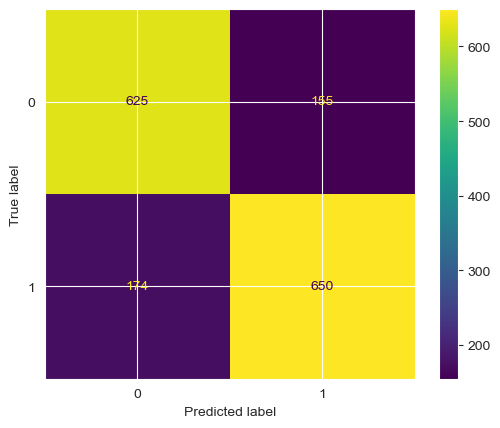

In [8]:
# Checking confusion matrix plot
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [9]:
# Compraing the result with random assignment sampled from distribution
## Getting distribution in Training set
distr = pd.DataFrame() 
distr['distr'] = y_train
distr = distr['distr'].value_counts().to_frame() 
distr_sum = distr['count'].sum()
distr['distr'] = distr['count'] / distr_sum

## Assigning labels at random based on the distribution
test_size = len(y_test)
random_pred = np.random.choice([0,1], size=test_size, p=[distr.at[0,'distr'], distr.at[1,'distr']])

print(classification_report(y_test,random_pred))

## Comparing the results
print("prediction f1 macro:")
print(f1_score(y_test, y_pred, average='macro'))

print("random f1 macro:")
print(f1_score(y_test, random_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.49      0.47      0.48       780
           1       0.52      0.53      0.53       824

    accuracy                           0.50      1604
   macro avg       0.50      0.50      0.50      1604
weighted avg       0.50      0.50      0.50      1604

prediction f1 macro:
0.7948379416614085
random f1 macro:
0.5027387102201561


d:\Program_Files\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


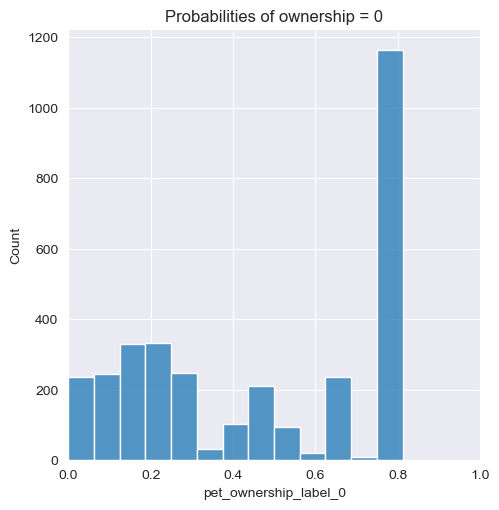

In [10]:
# Checking probability distributions post prediction
don_prob_pred = [model.predict_proba(X_train.values)]
df_don_prob_pred = pd.DataFrame(don_prob_pred[0], columns = ['pet_ownership_label_0', 'pet_ownership_label_1'])

# Label 0
sns.displot(df_don_prob_pred['pet_ownership_label_0'])
lim = plt.xlim([0,1])
ttl = plt.title(f'Probabilities of ownership = 0')
plt.show()

d:\Program_Files\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


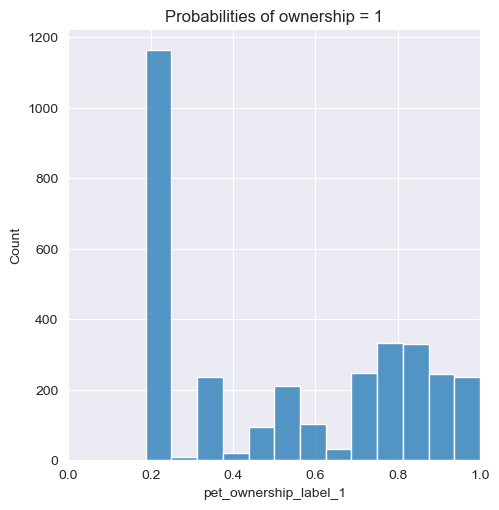

In [11]:
# Label 1
sns.displot(df_don_prob_pred['pet_ownership_label_1'])
lim = plt.xlim([0,1])
ttl = plt.title(f'Probabilities of ownership = 1')
plt.show()

In [12]:
# Predicting probabilities for the full data scope
probs = [model.predict_proba(df_feat.drop(columns='user_id').values)]
probs_df = pd.DataFrame(probs[0], columns = ['pet_ownership_label_0', 'pet_ownership_label_1'])
df_for_optimization = df.copy()
df_for_optimization[['pet_ownership_label_0', 'pet_ownership_label_1']] = probs_df[['pet_ownership_label_0', 'pet_ownership_label_1']]

In [13]:
# Checking the head of the dataframe
df_for_optimization.head()

,user_id,pet_ownership_label,dry_food_purchases,wet_food_purchases,treats_purchases,pet_ownership_label_0,pet_ownership_label_1
0,user_0,1,2.6,3.4,6.1,0.000122,0.999878
1,user_1,1,2.0,0.0,1.0,0.080741,0.919259
2,user_2,1,1.1,1.0,1.7,0.115975,0.884025
3,user_3,1,1.1,1.0,1.2,0.171979,0.828021
4,user_4,1,1.8,1.0,1.0,0.080978,0.919022


# Linear Optimization (Label Reassignment)
### Having predicted the ownership probabilities, now we need to re-assign labels using GLOP solver

In [14]:
# The goal is to maintain the current distribution of 0/1 labels, thus checking it below:
df_for_optimization['pet_ownership_label'].value_counts(normalize=True)

pet_ownership_label
1    0.522741
0    0.477259
Name: proportion, dtype: float64

In [15]:
# Current proprotion of owners (label = 1) is 52.2%, thus let's set our thresholds to +- 0.5 pp of that
target_upper_bound = 0.527
target_lower_bound = 0.517

In [16]:
# Defining cost function
# We want to encourage statues quo by making it harder to flip users that have ownership probability close to 50%
# Therefore, we define the below cost function:
target_col = 'pet_ownership_label'
df_for_optimization[f'{target_col}_no'] = 1 - df_for_optimization[target_col]
df_for_optimization['cost_1'] = (1 - df_for_optimization[f'{target_col}_1']) / (1 + df_for_optimization[target_col])              #increases cost of flipping to 1 if current label is 0
df_for_optimization['cost_0'] = (1 - df_for_optimization[f'{target_col}_0']) / (1 + df_for_optimization[f'{target_col}_no'])      #increases cost of flipping to 0 if current label is 1

In [17]:
# Defining the solver parameters
target_upper_bound2 = int(len(df_for_optimization)*target_upper_bound)
target_lower_bound2 = int(len(df_for_optimization)*target_lower_bound)
df_for_optimization = df_for_optimization.reset_index(drop=False)

# Defining the costs
costs = df_for_optimization[['cost_0','cost_1']].values
num_workers = len(costs)
num_tasks = len(costs[0])

# Initializing the solver
solver = pywraplp.Solver.CreateSolver("GLOP")

# x[i, j] is an array of 0-1 variables, which will be 1
# if user i is assigned to label j.
x = {}
for i in range(num_workers):
    for j in range(num_tasks):
        x[i, j] = solver.IntVar(0, 1, f"{i}_{j}")
        
# CONSTRAINTS        
# Each user is assigned to at most 1 label.
for i in range(num_workers):
    solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) == 1)

# Maximum target constraint (label = 1)
solver.Add(solver.Sum([x[i, 1] for i in range(num_workers)]) <= target_upper_bound2) #max target

# Minimum target constraint (label = 1)
solver.Add(solver.Sum([x[i, 1] for i in range(num_workers)]) >= target_lower_bound2) #min target

objective_terms = []
for i in range(num_workers):
    for j in range(num_tasks):
        objective_terms.append(costs[i][j] * x[i, j])
solver.Minimize(solver.Sum(objective_terms))

status = solver.Solve()

list_worker = []
list_value = []
list_cost = []

if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    print(f"Total cost = {solver.Objective().Value()}\n")
    for i in range(num_workers):
        for j in range(num_tasks):
            # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
            if x[i, j].solution_value() > 0.5:                
                list_worker.append(i)
                list_value.append(j)
                list_cost.append(costs[i][j])
else:
    print("No solution found.")

# Adding the result to the dataframe    
df_for_optimization_result = pd.DataFrame()
df_for_optimization_result['index'] = list_worker
df_for_optimization_result['assignment'] = list_value
df_for_optimization_result['cost'] = list_cost


df_for_optimization_post_optim = df_for_optimization.copy().merge(df_for_optimization_result, how='left', on='index')

# Identifying users that were flipped
def if_flipped(before, after):
    if before == after:
        return 'no'
    else:
        return f'{before}_>_{after}'

df_for_optimization_post_optim['if_flipped'] = df_for_optimization_post_optim.apply(lambda x: if_flipped(x[target_col], x['assignment']), axis=1) 

Total cost = 651.3402029401649



# Checking the optimization results

In [18]:
# Checking the DF head
df_for_optimization_post_optim[['user_id', 'pet_ownership_label', 'pet_ownership_label_1', 'assignment', 'if_flipped']].sample(10).head(10)

,user_id,pet_ownership_label,pet_ownership_label_1,assignment,if_flipped
2104,user_2104,1,0.648977,1,no
1152,user_1152,1,0.720075,1,no
1402,user_1402,1,0.738217,1,no
2344,user_2344,0,0.964265,1,0_>_1
4667,user_4668,0,0.525121,0,no
2172,user_2172,1,0.188230,0,1_>_0
421,user_421,0,0.188230,0,no
2631,user_2631,1,0.885696,1,no
2690,user_2691,0,0.188230,0,no
2190,user_2190,1,0.592965,1,no


In [19]:
# Checking the flip statistics
df_for_optimization_post_optim['if_flipped'].value_counts()

if_flipped
no       4183
0_>_1     348
1_>_0     328
Name: count, dtype: int64

In [20]:
# Original proportion of label = 1 was 52.2%, checking the results after reassignment:
df_for_optimization_post_optim['assignment'].value_counts(normalize=True)

assignment
1    0.526857
0    0.473143
Name: proportion, dtype: float64

d:\Program_Files\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


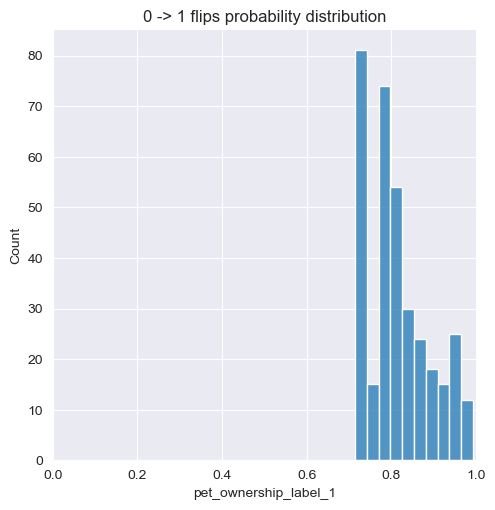

In [21]:
# Post-reassignment result is within the instructed +- 0.5 pp bounds

# Checking the ownership probabilities of users that were flipped

# 0 -> 1
df_0_1 = df_for_optimization_post_optim[df_for_optimization_post_optim['if_flipped']== '0_>_1']
sns.displot(df_0_1[f'{target_col}_1'])
lim = plt.xlim([0,1])
ttl = plt.title(f'0 -> 1 flips probability distribution')
plt.show()

d:\Program_Files\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


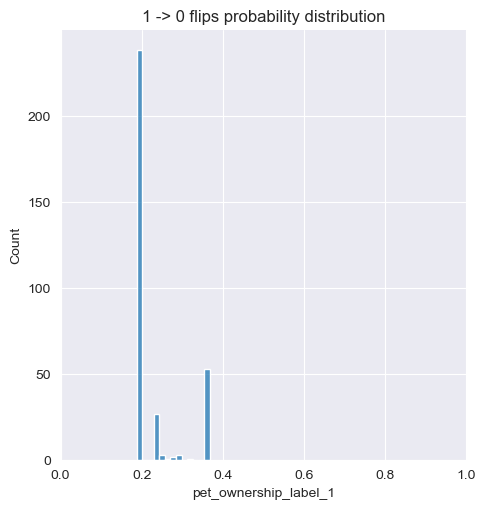

In [22]:
# As visible above, users that were flipped from self-reported non-owners to owners have high (~70%+) probability to be an owner based on their purchase behavior.

# 1 -> 0 
df_1_0 = df_for_optimization_post_optim[df_for_optimization_post_optim['if_flipped']== '1_>_0']
sns.displot(df_1_0[f'{target_col}_1'])
lim = plt.xlim([0,1])
ttl = plt.title(f'1 -> 0 flips probability distribution')
plt.show()

In [23]:
# Similarly, users that were flipped from self-reported owners to non-owners have low (~37% and below) probability to be an owner based on their purchase behavior.

# Done!
## We have successfully reassigned ownership labels based on purchasing behavior with the lowest possible cost while maintaining the original label distribution.